In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

In [2]:
# 1. LOAD AND CLEAN DATA
df = pd.read_csv('imdb_cleaned.csv')

# Merging categories
df['movie'] = (df['movie'] | (df['tvMovie'])).astype(int)
df['short'] = (df['short'] | (df['tvShort'])).astype(int)
df['tvSeries'] = (df['tvSeries'] | (df['tvMiniSeries'])).astype(int)
df.drop(columns=['tvMiniSeries', 'tvMovie', 'tvShort','videoGame'], inplace=True)

df.columns

Index(['startYear', 'runtimeMinutes', 'totalCredits', 'numRegions',
       'ratingCount', 'castNumber', 'companiesNumber', 'writerCredits',
       'directorsCredits', 'totalNominations', 'totalMedia', 'totalReviews',
       'Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania',
       'Continent Unknown', 'genre1', 'genre2', 'genre3', 'movie', 'short',
       'tvEpisode', 'tvSeries', 'tvSpecial', 'video', 'rating_bin'],
      dtype='object')

In [3]:
titletype_cols = ['movie', 'short', 'tvEpisode', 'tvSeries', 'tvSpecial', 'video']

In [4]:
# 2. TRAIN-TEST-VAL SPLIT
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[titletype_cols])
train, val = train_test_split(train, test_size=0.25, random_state=42, stratify=train[titletype_cols])

In [5]:
# 3. FEATURE SELECTION
numerical_cols = [
    'startYear', 'runtimeMinutes', 'totalCredits', 'numRegions', 
    'ratingCount', 'castNumber', 'companiesNumber', 'writerCredits', 
    'directorsCredits', 'totalNominations', 'totalMedia', 'totalReviews', 'rating_bin'
]
region_cols = ['Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania', 'Continent Unknown']
genre_cols = ['genre1', 'genre2', 'genre3']

selected_features = numerical_cols + region_cols + genre_cols
to_scale = [feat for feat in selected_features if feat not in titletype_cols]

X_train_df = train[selected_features].copy()
X_val_df = val[selected_features].copy()
X_test_df = test[selected_features].copy()

In [6]:
y_test = test[titletype_cols]

In [7]:
# 4. LOG TRANSFORMATION
to_log = ['numRegions', 'ratingCount', 'companiesNumber', 'totalNominations', 'totalMedia', 'totalReviews']
for col in to_log:
    X_train_df[col] = np.log1p(X_train_df[col].fillna(0).clip(lower=0))
    X_val_df[col] = np.log1p(X_val_df[col].fillna(0).clip(lower=0))
    X_test_df[col] = np.log1p(X_test_df[col].fillna(0).clip(lower=0))

In [8]:
# 5. SCALING
scaler = StandardScaler()
X_train_df[to_scale] = scaler.fit_transform(X_train_df[to_scale])
X_val_df[to_scale] = scaler.transform(X_val_df[to_scale])
X_test_df[to_scale] = scaler.transform(X_test_df[to_scale])

In [9]:
# 6. COMBINING FOR SHAP (Converting to Numpy)
X_train_combined = X_train_df.values
X_test_combined = X_test_df.values
feature_names = list(X_train_df.columns)
class_names = titletype_cols

In [10]:
# 7. LOAD MODEL
model_titletype = keras.models.load_model("neural_net_titletype.keras")

In [11]:
# 8. SHAP EXPLAINER SETUP
# We use KernelExplainer for Keras models. 
# We use a 100-row summary of the training set as the 'background' to speed up calculations.
background_summary = shap.sample(X_train_combined, 100)

def predict_wrapper(x):
    """Maps the 2D numpy array SHAP uses back into the dictionary format your model expects."""
    return model_titletype.predict({
        'numerical': x[:, :len(numerical_cols)],
        'region': x[:, len(numerical_cols):len(numerical_cols)+len(region_cols)],
        'genre': x[:, len(numerical_cols)+len(region_cols):]
    }, verbose=0)

explainer = shap.KernelExplainer(predict_wrapper, background_summary)

In [20]:
%%time
# 9. EXPLAIN A SINGLE INSTANCE
instance_idx = 0
instance = X_test_combined[instance_idx].reshape(1, -1)

# Get prediction for context
pred_probs = predict_wrapper(instance)
predicted_class_idx = np.argmax(pred_probs)
true_class_idx = np.argmax(y_test.iloc[instance_idx].values)

print(f"True Class: {class_names[true_class_idx]}")
print(f"Predicted Class: {class_names[predicted_class_idx]}")

# Calculate SHAP values (this takes some time)
shap_values = explainer.shap_values(instance)

True Class: movie
Predicted Class: movie


  0%|          | 0/1 [00:00<?, ?it/s]

--- Final Alignment ---
Features: 23, SHAP values: 23


<Figure size 2000x300 with 0 Axes>

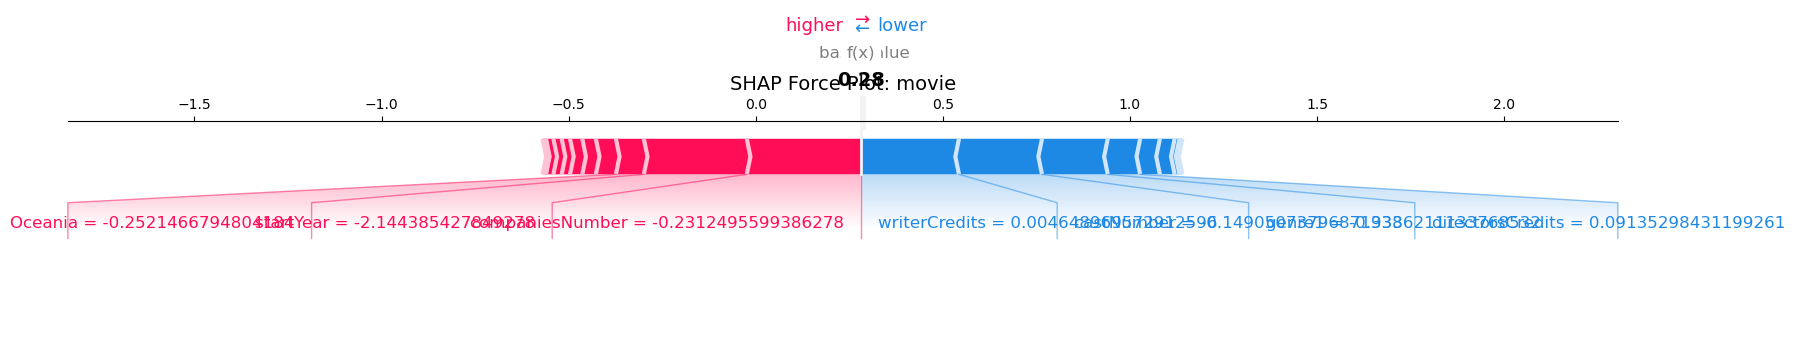

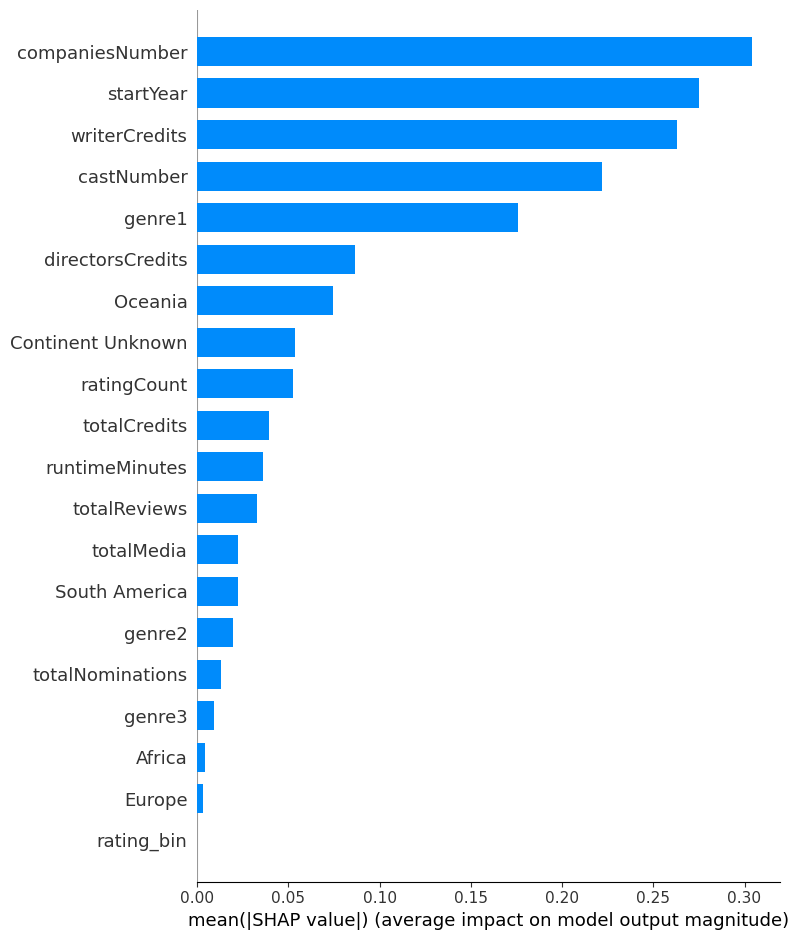

In [17]:
# 10. VISUALIZATION
import matplotlib.pyplot as plt
import numpy as np

# 1. Align dimensions (same logic as before)
n_features = len(feature_names)
current_shap_values = np.array(shap_values[predicted_class_idx]).flatten()[:n_features]
current_instance_features = instance.flatten()[:n_features]
base_value = explainer.expected_value[predicted_class_idx]

print(f"--- Final Alignment ---")
print(f"Features: {n_features}, SHAP values: {len(current_shap_values)}")

# 2. FORCE PLOT (Single Instance)
# We use the standard matplotlib=True call
plt.figure(figsize=(20, 3))
shap.force_plot(
    base_value, 
    current_shap_values, 
    features=current_instance_features, 
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot: {class_names[predicted_class_idx]}", fontsize=14)
plt.show()

# 3. BAR PLOT (Using summary_plot for stability)
# summary_plot is the most stable function across SHAP versions for numpy arrays
plt.figure(figsize=(10, 6))
shap.summary_plot(
    current_shap_values.reshape(1, -1), # Needs 2D (1 sample, N features)
    features=current_instance_features.reshape(1, -1),
    feature_names=feature_names,
    plot_type="bar"
)

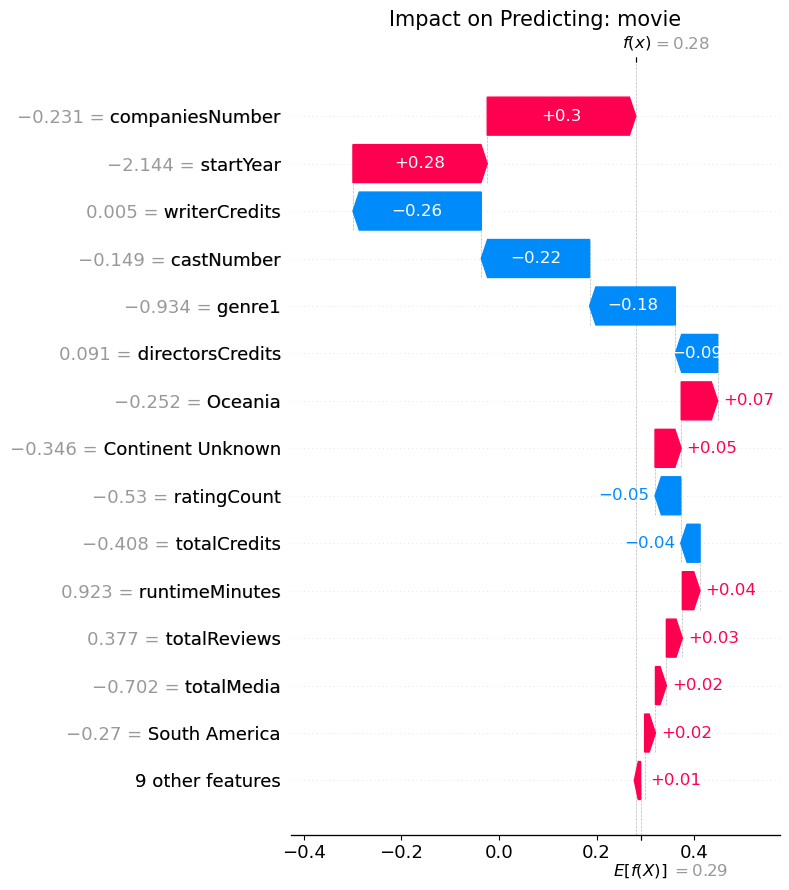

In [18]:
# --- CLEAN WATERFALL PLOT ---
import matplotlib.pyplot as plt

# 1. Align dimensions
n_features = len(feature_names)
current_shap_values = np.array(shap_values[predicted_class_idx]).flatten()[:n_features]
current_instance_features = instance.flatten()[:n_features]
base_value = explainer.expected_value[predicted_class_idx]

# 2. Create an Explanation object (this is what the modern SHAP plots prefer)
# This allows SHAP to handle the formatting automatically
exp = shap.Explanation(
    values=current_shap_values,
    base_values=base_value,
    data=current_instance_features,
    feature_names=feature_names
)

# 3. Plot
plt.figure(figsize=(10, 8))
shap.plots.waterfall(exp, max_display=15, show=False)
plt.title(f"Impact on Predicting: {class_names[predicted_class_idx]}", fontsize=15)
plt.tight_layout()
plt.show()

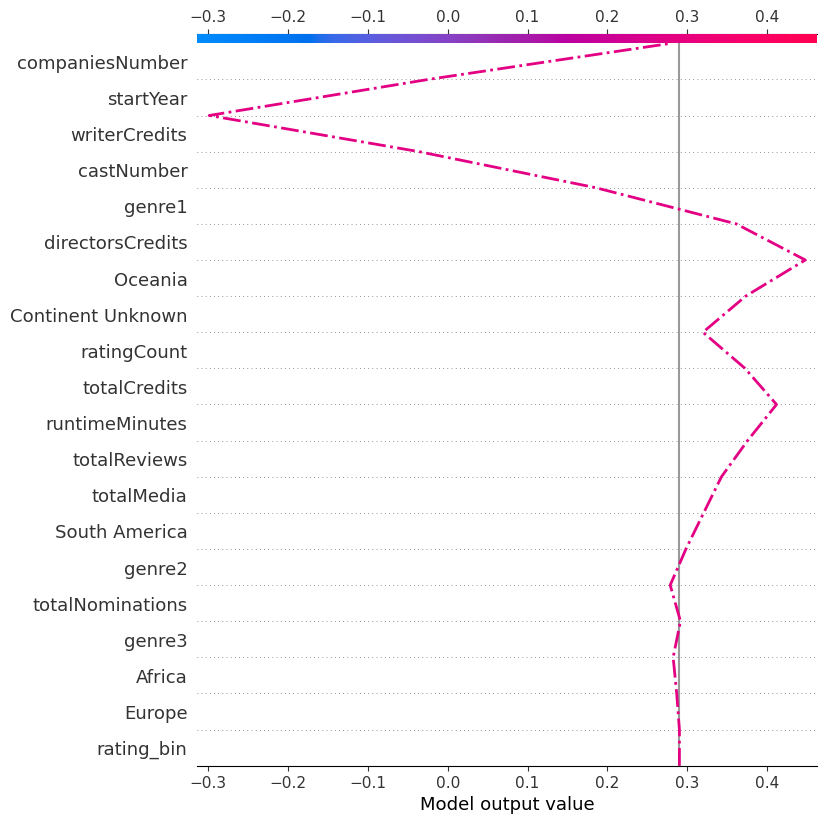

In [19]:
# --- CLEAN DECISION PLOT ---
plt.figure(figsize=(10, 8))
shap.decision_plot(
    base_value, 
    current_shap_values, 
    feature_names=feature_names,
    highlight=0 # Highlights the path
)
plt.show()

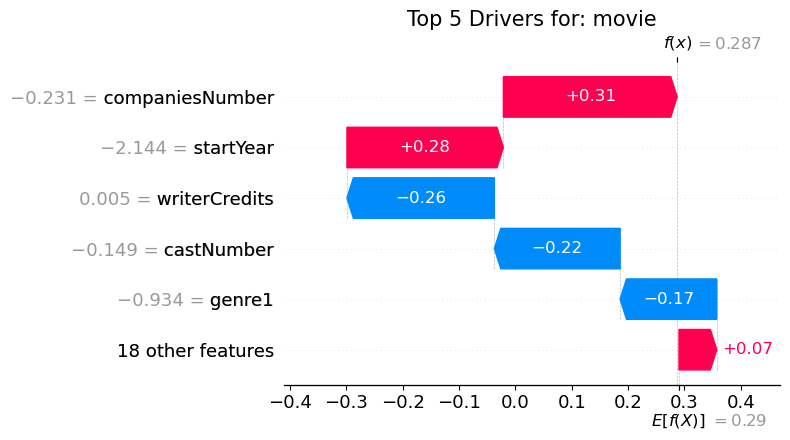

In [ ]:
# --- CLEAN WATERFALL PLOT (TOP 5 FEATURES) ---
import matplotlib.pyplot as plt

# 1. Align dimensions (as we did before)
n_features = len(feature_names)
current_shap_values = np.array(shap_values[predicted_class_idx]).flatten()[:n_features]
current_instance_features = instance.flatten()[:n_features]
base_value = explainer.expected_value[predicted_class_idx]

# 2. Create the Explanation object
exp = shap.Explanation(
    values=current_shap_values,
    base_values=base_value,
    data=current_instance_features,
    feature_names=feature_names
)

# 3. Plot with max_display=5
plt.figure(figsize=(10, 6))
# max_display=5 shows the 5 most impactful features and groups the rest into "Other"
shap.plots.waterfall(exp, max_display=6, show=False) 

plt.title(f"Top 5 Features for: {class_names[predicted_class_idx]}", fontsize=15)
plt.tight_layout()
plt.show()

True Class: tvEpisode
Predicted Class: tvSeries (Index: 3)


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP returned an array of shape: (1, 23, 6)


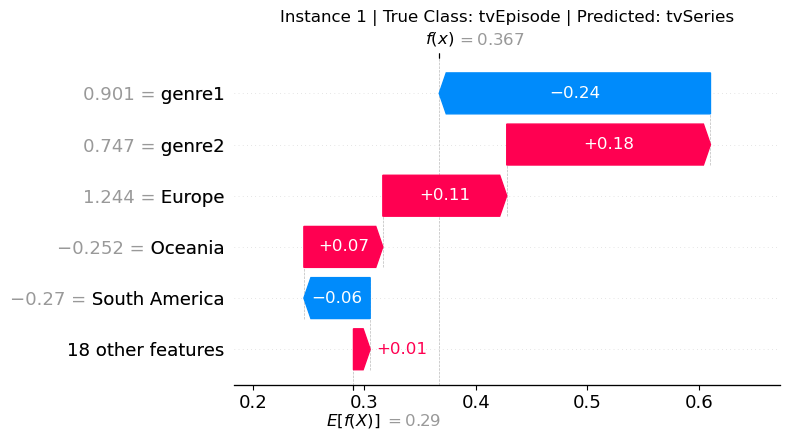

CPU times: total: 18.8 s
Wall time: 17.6 s


In [ ]:
%%time
# 9. EXPLAIN A SINGLE INSTANCE
instance_idx = 1 
instance = X_test_combined[instance_idx].reshape(1, -1)

# Get prediction
pred_probs = predict_wrapper(instance)
predicted_class_idx = np.argmax(pred_probs)
true_class_idx = np.argmax(y_test.iloc[instance_idx].values)

print(f"True Class: {class_names[true_class_idx]}")
print(f"Predicted Class: {class_names[predicted_class_idx]} (Index: {predicted_class_idx})")

# Calculate SHAP values
# We wrap this in a try-block to catch the exact shape if it fails
shap_results = explainer.shap_values(instance)

# --- THE ROBUST ALIGNMENT LOGIC ---
try:
    # 1. Handle SHAP values
    # If KernelExplainer returns a list of length 6, we grab the array for our class
    if isinstance(shap_results, list):
        print(f"SHAP returned a list of length: {len(shap_results)}")
        # Safety: if the list is shorter than our predicted index, default to 0
        idx = predicted_class_idx if predicted_class_idx < len(shap_results) else 0
        val_array = np.array(shap_results[idx])
    else:
        # If it's a 3D numpy array (Classes, Samples, Features)
        print(f"SHAP returned an array of shape: {shap_results.shape}")
        idx = predicted_class_idx if predicted_class_idx < shap_results.shape[0] else 0
        val_array = shap_results[idx]

    # 2. Flatten to 1D (Length 23)
    current_shap_values = val_array.flatten()
    
    # 3. Handle Expected Values
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_value = explainer.expected_value[idx]
    else:
        base_value = explainer.expected_value

except Exception as e:
    print(f"Custom Alignment failed: {e}")
    # Emergency Fallback: Just take whatever SHAP gave us and force it to 23 features
    current_shap_values = np.array(shap_results).flatten()[:23]
    base_value = 0.5 

# --- PLOTTING ---
import matplotlib.pyplot as plt

# Align features
current_instance_features = instance.flatten()[:23]
current_shap_values = current_shap_values[:23]

exp = shap.Explanation(
    values=current_shap_values,
    base_values=float(base_value),
    data=current_instance_features,
    feature_names=feature_names[:23]
)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(exp, max_display=6, show=False) 
plt.title(f"Instance {instance_idx} | True Class: {class_names[true_class_idx]} | Predicted: {class_names[predicted_class_idx]}", fontsize=14)
plt.tight_layout()
plt.show()

True Class: tvEpisode
Predicted Class: tvEpisode (Index: 2)


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP returned an array of shape: (1, 23, 6)


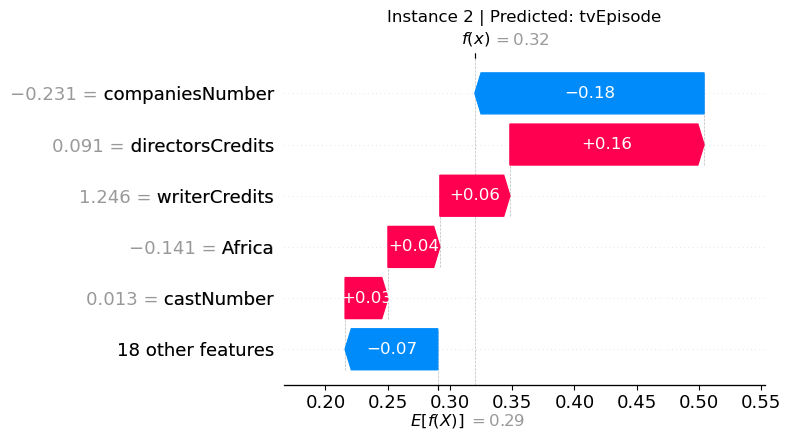

CPU times: total: 18.7 s
Wall time: 15.7 s


In [30]:
%%time
# 9. EXPLAIN A SINGLE INSTANCE
instance_idx = 2 
instance = X_test_combined[instance_idx].reshape(1, -1)

# Get prediction
pred_probs = predict_wrapper(instance)
predicted_class_idx = np.argmax(pred_probs)
true_class_idx = np.argmax(y_test.iloc[instance_idx].values)

print(f"True Class: {class_names[true_class_idx]}")
print(f"Predicted Class: {class_names[predicted_class_idx]} (Index: {predicted_class_idx})")

# Calculate SHAP values
# We wrap this in a try-block to catch the exact shape if it fails
shap_results = explainer.shap_values(instance)

# --- THE ROBUST ALIGNMENT LOGIC ---
try:
    # 1. Handle SHAP values
    # If KernelExplainer returns a list of length 6, we grab the array for our class
    if isinstance(shap_results, list):
        print(f"SHAP returned a list of length: {len(shap_results)}")
        # Safety: if the list is shorter than our predicted index, default to 0
        idx = predicted_class_idx if predicted_class_idx < len(shap_results) else 0
        val_array = np.array(shap_results[idx])
    else:
        # If it's a 3D numpy array (Classes, Samples, Features)
        print(f"SHAP returned an array of shape: {shap_results.shape}")
        idx = predicted_class_idx if predicted_class_idx < shap_results.shape[0] else 0
        val_array = shap_results[idx]

    # 2. Flatten to 1D (Length 23)
    current_shap_values = val_array.flatten()
    
    # 3. Handle Expected Values
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_value = explainer.expected_value[idx]
    else:
        base_value = explainer.expected_value

except Exception as e:
    print(f"Custom Alignment failed: {e}")
    # Emergency Fallback: Just take whatever SHAP gave us and force it to 23 features
    current_shap_values = np.array(shap_results).flatten()[:23]
    base_value = 0.5 

# --- PLOTTING ---
import matplotlib.pyplot as plt

# Align features
current_instance_features = instance.flatten()[:23]
current_shap_values = current_shap_values[:23]

exp = shap.Explanation(
    values=current_shap_values,
    base_values=float(base_value),
    data=current_instance_features,
    feature_names=feature_names[:23]
)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(exp, max_display=6, show=False) 
plt.title(f"Instance {instance_idx} | Predicted: {class_names[predicted_class_idx]}", fontsize=12)
plt.tight_layout()
plt.show()

True Class: movie
Predicted Class: movie (Index: 0)


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP returned an array of shape: (1, 23, 6)


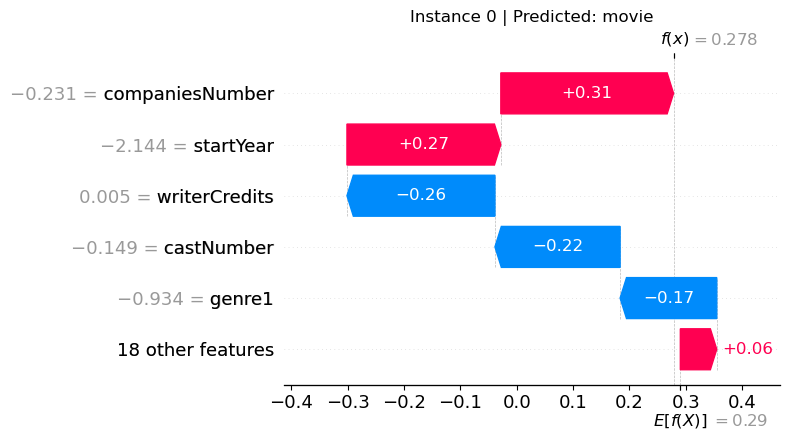

CPU times: total: 17.5 s
Wall time: 45.8 s


In [ ]:
%%time
# 9. EXPLAIN A SINGLE INSTANCE
instance_idx = 0 
instance = X_test_combined[instance_idx].reshape(1, -1)

# Get prediction
pred_probs = predict_wrapper(instance)
predicted_class_idx = np.argmax(pred_probs)
true_class_idx = np.argmax(y_test.iloc[instance_idx].values)

print(f"True Class: {class_names[true_class_idx]}")
print(f"Predicted Class: {class_names[predicted_class_idx]} (Index: {predicted_class_idx})")

# Calculate SHAP values
# We wrap this in a try-block to catch the exact shape if it fails
shap_results = explainer.shap_values(instance)

# --- THE ROBUST ALIGNMENT LOGIC ---
try:
    # 1. Handle SHAP values
    # If KernelExplainer returns a list of length 6, we grab the array for our class
    if isinstance(shap_results, list):
        print(f"SHAP returned a list of length: {len(shap_results)}")
        # Safety: if the list is shorter than our predicted index, default to 0
        idx = predicted_class_idx if predicted_class_idx < len(shap_results) else 0
        val_array = np.array(shap_results[idx])
    else:
        # If it's a 3D numpy array (Classes, Samples, Features)
        print(f"SHAP returned an array of shape: {shap_results.shape}")
        idx = predicted_class_idx if predicted_class_idx < shap_results.shape[0] else 0
        val_array = shap_results[idx]

    # 2. Flatten to 1D (Length 23)
    current_shap_values = val_array.flatten()
    
    # 3. Handle Expected Values
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        base_value = explainer.expected_value[idx]
    else:
        base_value = explainer.expected_value

except Exception as e:
    print(f"Custom Alignment failed: {e}")
    # Emergency Fallback: Just take whatever SHAP gave us and force it to 23 features
    current_shap_values = np.array(shap_results).flatten()[:23]
    base_value = 0.5 

# --- PLOTTING ---
import matplotlib.pyplot as plt

# Align features
current_instance_features = instance.flatten()[:23]
current_shap_values = current_shap_values[:23]

exp = shap.Explanation(
    values=current_shap_values,
    base_values=float(base_value),
    data=current_instance_features,
    feature_names=feature_names[:23]
)

plt.figure(figsize=(10, 6))
shap.plots.waterfall(exp, max_display=6, show=False) 
plt.title(f"Instance {instance_idx} | True Class: {class_names[true_class_idx]} | Predicted: {class_names[predicted_class_idx]}", fontsize=12)
plt.tight_layout()
plt.show()